<a href="https://colab.research.google.com/github/zeeshan1047/research/blob/main/final_Rnn_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df =pd.read_excel('/content/drive/MyDrive/translation research/dataset/eu_dataset.xlsx')

# Inspect the dataframe
df.head(10)


,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔
5,above all be patient,سب سے بڑھ کر صبر کرو
6,i learned it from him,میں نے اسے اس سے سیکھا۔
7,why am i doing this,میں یہ کیوں کر رہا ہوں
8,i made a bad decision,میں نے ایک برا فیصلہ کیا
9,zain wont care,زین پرواہ نہیں کرے گا


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Example dataset (replace with your data loading code)

# Tokenization
english_text = df['English'].astype(str)
urdu_text = df['Urdu'].astype(str)
english_tokenizer = Tokenizer(oov_token='<OOV>')
urdu_tokenizer = Tokenizer(oov_token='<OOV>')
english_tokenizer.fit_on_texts(english_text)
urdu_tokenizer.fit_on_texts(urdu_text)
print(english_tokenizer.word_index)
print(urdu_tokenizer.word_index)



{'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'is': 5, 'to': 6, 'i': 7, 'you': 8, 'a': 9, 'in': 10, 'that': 11, 'he': 12, 'they': 13, 'for': 14, 'not': 15, 'it': 16, 'him': 17, 'them': 18, 'are': 19, 'have': 20, 'be': 21, 'we': 22, 'with': 23, 'will': 24, 'was': 25, 'but': 26, 'this': 27, 'his': 28, 'allah': 29, 'zain': 30, 'who': 31, 'all': 32, 'your': 33, 'do': 34, 'which': 35, 'from': 36, 'good': 37, 'me': 38, 'my': 39, 'unto': 40, 'their': 41, 'as': 42, 'so': 43, 'by': 44, 'on': 45, 'when': 46, 'shall': 47, 'then': 48, 'am': 49, 'said': 50, 'food': 51, 'lord': 52, 'were': 53, 'there': 54, 'one': 55, 'what': 56, 'ye': 57, 'god': 58, 'has': 59, 'if': 60, 'those': 61, 'no': 62, 'had': 63, 'say': 64, 'people': 65, 'also': 66, 'at': 67, 'very': 68, 'come': 69, 'us': 70, 'man': 71, 'out': 72, 'or': 73, 'our': 74, 'place': 75, 'like': 76, 'up': 77, 'jesus': 78, 'its': 79, 'did': 80, 'day': 81, 'into': 82, 'an': 83, 'she': 84, 'know': 85, 'may': 86, 'any': 87, 'these': 88, 'can': 89, 'now': 90

In [ ]:
import pickle
import os

# Define the paths
english_tokenizer_path = '/content/drive/MyDrive/translation research/english_tokenizer.pkl'
urdu_tokenizer_path = '/content/drive/MyDrive/translation research/urdu_tokenizer.pkl'

# Save English tokenizer
with open(english_tokenizer_path, 'wb') as file:
    pickle.dump(english_tokenizer, file)

# Save Urdu tokenizer
with open(urdu_tokenizer_path, 'wb') as file:
    pickle.dump(urdu_tokenizer, file)


In [ ]:
input_vocab_size = len(english_tokenizer.word_index) + 1
target_vocab_size = len(urdu_tokenizer.word_index) + 1

print(input_vocab_size)
print(target_vocab_size)


16551
20062


In [ ]:
# Sequencing
english_sequences = english_tokenizer.texts_to_sequences(english_text)
urdu_sequences = urdu_tokenizer.texts_to_sequences(urdu_text)
max_len = max(max(len(seq) for seq in english_sequences), max(len(seq) for seq in urdu_sequences)) # Removed extra len() call

print(max_len)

232


In [ ]:
max_len = 234

In [ ]:
#padding
english_sequences_padded = pad_sequences(english_sequences, maxlen=max_len, padding='post')
urdu_sequences_padded = pad_sequences(urdu_sequences, maxlen=max_len, padding='post')

print(english_sequences_padded[0:10])
print(urdu_sequences_padded[0:10])


[[   5   30   33 ...    0    0    0]
 [   7  630 2482 ...    0    0    0]
 [  80   12  906 ...    0    0    0]
 ...
 [ 174   49    7 ...    0    0    0]
 [   7   97    9 ...    0    0    0]
 [  30  507  832 ...    0    0    0]]
[[  34  393 8808 ...    0    0    0]
 [ 742   33  292 ...    0    0    0]
 [  19   16    9 ...    0    0    0]
 ...
 [   5   17  196 ...    0    0    0]
 [   5    9   25 ...    0    0    0]
 [  34 1849   13 ...    0    0    0]]


In [ ]:
# Splitting the dataset
train_english, val_english, train_urdu, val_urdu = train_test_split(
    english_sequences_padded, urdu_sequences_padded, test_size=0.2, random_state=42
)

print(train_english.shape)
print(val_english.shape)

print(train_urdu.shape)
print(val_urdu.shape)


(36056, 234)
(9015, 234)
(36056, 234)
(9015, 234)


In [ ]:
train_data = {'encoder_input': train_english, 'decoder_input': train_urdu}
val_data = {'encoder_input': val_english, 'decoder_input': val_urdu}

print(train_data)
print(val_data)

{'encoder_input': array([[   16,    25,   161, ...,     0,     0,     0],
       [    3,    54,   103, ...,     0,     0,     0],
       [   13,  1403,    68, ...,     0,     0,     0],
       ...,
       [   57,   121,    95, ...,     0,     0,     0],
       [   12,   240,   105, ...,     0,     0,     0],
       [   34,     8, 11007, ...,     0,     0,     0]], dtype=int32), 'decoder_input': array([[  17,  174, 1017, ...,    0,    0,    0],
       [   2,  205,    7, ...,    0,    0,    0],
       [  10,   40,  495, ...,    0,    0,    0],
       ...,
       [ 293,   24,   90, ...,    0,    0,    0],
       [  16,    9,   57, ...,    0,    0,    0],
       [  19,   23, 9296, ...,    0,    0,    0]], dtype=int32)}
{'encoder_input': array([[  62,  549,  101, ...,    0,    0,    0],
       [ 659,  741,    0, ...,    0,    0,    0],
       [4567,   72,    0, ...,    0,    0,    0],
       ...,
       [  22,   48,  879, ...,    0,    0,    0],
       [  27,    5,   39, ...,    0,    0,   

In [ ]:
# RNN Model architecture
input_encoder = Input(shape=(max_len,), name='encoder_input')
input_decoder = Input(shape=(max_len,), name='decoder_input')



In [ ]:
# Parameters
d_model = 256
embedding_layer = Embedding(input_dim=input_vocab_size, output_dim=d_model)

# Encoder
encoder_inputs = embedding_layer(input_encoder)
encoder_rnn = SimpleRNN(d_model, return_sequences=True, dropout=0.1)(encoder_inputs)
encoder_outputs = LayerNormalization(epsilon=1e-6)(encoder_rnn)

# Decoder
decoder_inputs = embedding_layer(input_decoder)
# Use the last timestep's output from the encoder as the initial state
initial_state = encoder_outputs[:,-1,:]
decoder_rnn = SimpleRNN(d_model, return_sequences=True, dropout=0.1)(decoder_inputs, initial_state=[initial_state])
decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder_rnn)

outputs = Dense(target_vocab_size, activation='softmax')(decoder_outputs)

# Model
rnn_model = Model(inputs=[input_encoder, input_decoder], outputs=outputs)

In [ ]:
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print(max_len)

234


In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('/content/drive/MyDrive/translation research/best_rnn_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)


In [ ]:
# Training function
def train_rnn_model(model, train_data, val_data, train_labels, val_labels, epochs, batch_size, callbacks):
    history = model.fit(
        x=[train_data['encoder_input'], train_data['decoder_input']],  # Input data
        y=train_labels,  # Target labels for training data
        validation_data=([val_data['encoder_input'], val_data['decoder_input']], val_labels),  # Validation data and labels
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
    return history


In [ ]:
history = train_rnn_model(rnn_model, train_data, val_data, train_urdu, val_urdu, epochs=20, batch_size=32, callbacks=[checkpoint, early_stopping])


Epoch 1/20
1127/1127 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.9721
Epoch 1: val_loss improved from inf to 0.05735, saving model to /content/drive/MyDrive/translation research/best_rnn_model.keras
1127/1127 [==============================] - 581s 511ms/step - loss: 0.3180 - accuracy: 0.9721 - val_loss: 0.0574 - val_accuracy: 0.9937
Epoch 2/20
1127/1127 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9968
Epoch 2: val_loss improved from 0.05735 to 0.02267, saving model to /content/drive/MyDrive/translation research/best_rnn_model.keras
1127/1127 [==============================] - 564s 500ms/step - loss: 0.0283 - accuracy: 0.9968 - val_loss: 0.0227 - val_accuracy: 0.9977
Epoch 3/20
1127/1127 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9994
Epoch 3: val_loss improved from 0.02267 to 0.01751, saving model to /content/drive/MyDrive/translation research/best_rnn_model.keras
1127/1127 [==========================

In [ ]:
rnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_input (InputLayer)  [(None, 234)]                0         []                            
                                                                                                  
 encoder_input (InputLayer)  [(None, 234)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 234, 256)             4237056   ['encoder_input[0][0]',       
                                                                     'decoder_input[0][0]']       
                                                                                                  
 simple_rnn_2 (SimpleRNN)    (None, 234, 256)             131328    ['embedding_1[0][0]']     

In [ ]:
# Extract the accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract the loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs_range = range(len(acc))

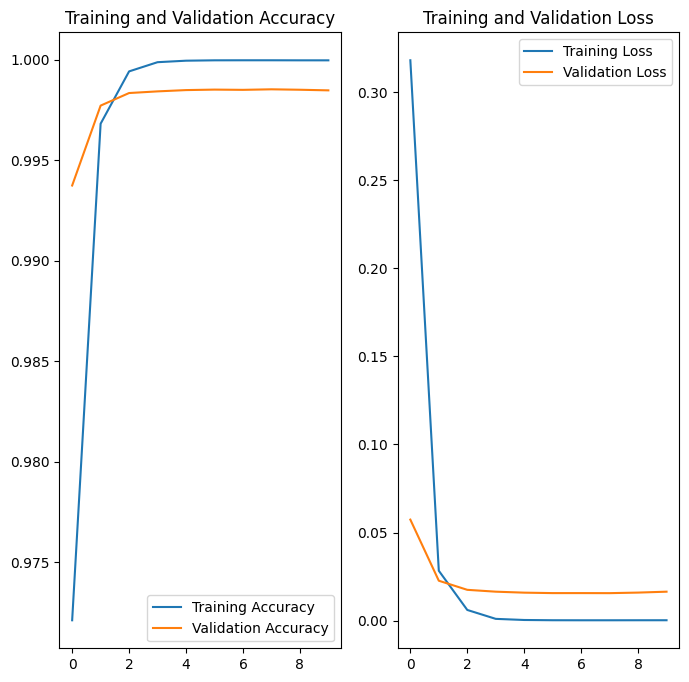

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Extract the accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract the loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs_range = range(len(acc))

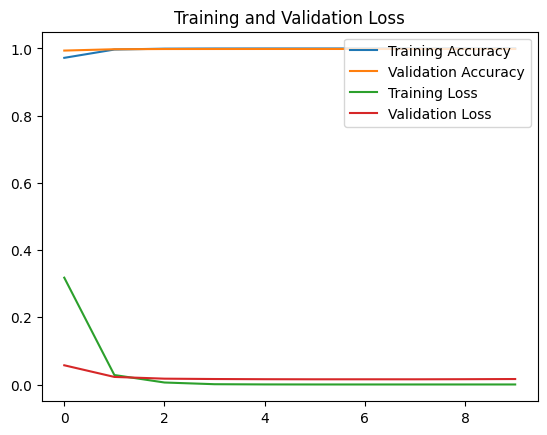

In [ ]:
# Plot the training and validation accuracy
#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pickle

# Define the paths
english_tokenizer_path = '/content/drive/MyDrive/translation research/english_tokenizer.pkl'
urdu_tokenizer_path = '/content/drive/MyDrive/translation research/urdu_tokenizer.pkl'

# Load English tokenizer
with open(english_tokenizer_path, 'rb') as file:
    english_tokenizer = pickle.load(file)

# Load Urdu tokenizer
with open(urdu_tokenizer_path, 'rb') as file:
    urdu_tokenizer = pickle.load(file)


In [ ]:
# Evaluate on test data
#validation_data=([val_data['encoder_input'], val_data['decoder_input']])  # Validation data and labels
#test_dataset = tf.data.Dataset.from_tensor_slices(english_sequences_padded, urdu_sequences_padded).batch(32)
# Evaluate on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/translation research/best_rnn_model.keras')
best_model.evaluate([val_english, val_urdu], val_urdu)

In [ ]:
val_english_small = val_english[:10]  # Adjust the size as needed
val_urdu_small = val_urdu[:10]  # Adjust the size as needed

# Predict with the smaller dataset
predictions = best_model.predict([val_english_small, val_urdu_small], batch_size=2)

In [ ]:
predicted_sequences = predictions.argmax(axis=-1)
predicted_text = urdu_tokenizer.sequences_to_texts(predicted_sequences)
# Iterate through each predicted sentence and remove '<OOV>' if present
for i in range(len(predicted_text)):
    predicted_text[i] = re.sub(r'\s*<OOV>\s*', ' ', predicted_text[i]).strip()

print(predicted_text)

In [ ]:
val_urdu_small
import re  # Import the 're' module for regular expression operations

text = urdu_tokenizer.sequences_to_texts(val_urdu_small)
for i in range(len(text)):
    predicted_text[i] = re.sub(r'\s*<OOV>\s*', ' ', predicted_text[i]).strip()

print(predicted_text)

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
import numpy as np

# Ensure NLTK data is downloaded
nltk.download('punkt')

In [ ]:


def tokenize(texts):
    """Tokenize texts into lists of tokens."""
    return [nltk.word_tokenize(text) for text in texts]

def compute_bleu_score(predictions, references):
    """Compute BLEU score using nltk."""
    # Tokenize the predictions and references
    tokenized_predictions = tokenize(predictions)
    tokenized_references = [tokenize(refs) for refs in references]

    # Compute BLEU score
    bleu_score = corpus_bleu(tokenized_references, tokenized_predictions)
    return bleu_score

# Example predictions and references
predictions = [
    'کسی جان کو اس کی طاقت سے بڑھ کر تکلیف نہ دی جائے ، اور نہ ماں کو اس کے بچے کے باعث نقصان پہنچایا جائے اور نہ باپ کو اس کی اولاد کے سبب سے ،',
    'وہ خوبصورت ہے',
    'ٹھنڈا',
    'وہ میری بہن نہیں ہے۔',
    'زین ویسے بھی کہاں ہے؟',
    'بزدل نہ بنو',
    'اور اگر مسِیح نہیں جی اُٹھا تو تُمہارا اِیمان بےفائِدہ ہے تُم اَب تک اپنے گُناہوں میں گِرفتار ہو ۔',
    'گوگل کے ذریعے ترجمہ کم قیمتوں میں مزیدار کراہی۔',
    'بیشک جو لوگ اللہ اور اُس کے رسول صلی اللہ علیہ وآلہ وسلم سے عداوت رکھتے ہیں وہی ذلیل ترین لوگوں میں سے ہیں ۔',
    'زین گھبرا گیا'
]

references = [
    'کسی جان کو اس کی طاقت سے بڑھ کر تکلیف نہ دی جائے ، اور نہ ماں کو اس کے بچے کے باعث نقصان پہنچایا جائے اور نہ باپ کو اس کی اولاد کے سبب سے ،',
    ['وہ خوبصورت ہے'],
    ['ٹھنڈا'],
    [ 'وہ میری بہن نہیں ہے۔'],
    ['زین ویسے بھی کہاں ہے؟'],
    ['بزدل نہ بنو'],
    ['اور اگر مسِیح نہیں جی اُٹھا تو تُمہارا اِیمان بےفائِدہ ہے تُم اَب تک اپنے گُناہوں میں گِرفتار ہو ۔'],
    ['گوگل کے ذریعے ترجمہ کم قیمتوں میں مزیدار کراہی۔'],
    ['بیشک جو لوگ اللہ اور اُس کے رسول صلی اللہ علیہ وآلہ وسلم سے عداوت رکھتے ہیں وہی ذلیل ترین لوگوں میں سے ہیں ۔'],
    ['زین گھبرا گیا']
]

# Compute BLEU score
bleu_score = compute_bleu_score(predictions, references)
print(f"BLEU score: {bleu_score:.4f}")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
def tokenize(texts):
    """Tokenize texts into lists of tokens."""
    return [nltk.word_tokenize(text) for text in texts]

def flatten(tokens_list):
    """Flatten a list of tokenized texts."""
    return [token for sublist in tokens_list for token in sublist]

def compute_confusion_matrix(predictions, references):
    """Compute confusion matrix for token-level predictions and references."""
    # Tokenize the predictions and references
    tokenized_predictions = tokenize(predictions)
    tokenized_references = tokenize(references)

    # Flatten tokenized lists
    flat_predictions = flatten(tokenized_predictions)
    flat_references = flatten(tokenized_references)

    # Create confusion matrix
    # We use unique tokens as classes
    labels = sorted(set(flat_predictions + flat_references))
    cm = confusion_matrix(flat_references, flat_predictions, labels=labels)

    return cm, labels

# Provided data
predictions = [
    'کسی جان کو اس کی طاقت سے بڑھ کر تکلیف نہ دی جائے ، اور نہ ماں کو اس کے بچے کے باعث نقصان پہنچایا جائے اور نہ باپ کو اس کی اولاد کے سبب سے ،',
    'وہ خوبصورت ہے',
    'ٹھنڈا',
    'وہ میری بہن نہیں ہے۔',
    'زین ویسے بھی کہاں ہے؟',
    'بزدل نہ بنو',
    'اور اگر مسِیح نہیں جی اُٹھا تو تُمہارا اِیمان بےفائِدہ ہے تُم اَب تک اپنے گُناہوں میں گِرفتار ہو ۔',
    'گوگل کے ذریعے ترجمہ کم قیمتوں میں مزیدار کراہی۔',
    'بیشک جو لوگ اللہ اور اُس کے رسول صلی اللہ علیہ وآلہ وسلم سے عداوت رکھتے ہیں وہی ذلیل ترین لوگوں میں سے ہیں ۔',
    'زین گھبرا گیا'
]

references = [
    'کسی جان کو اس کی طاقت سے بڑھ کر تکلیف نہ دی جائے ، اور نہ ماں کو اس کے بچے کے باعث نقصان پہنچایا جائے اور نہ باپ کو اس کی اولاد کے سبب سے ،',
    'وہ خوبصورت ہے', # Changed this to a string
    'ٹھنڈا', # Changed this to a string
    'وہ میری بہن نہیں ہے۔', # Changed this to a string
    'زین ویسے بھی کہاں ہے؟', # Changed this to a string
    'بزدل نہ بنو', # Changed this to a string
    'اور اگر مسِیح نہیں جی اُٹھا تو تُمہارا اِیمان بےفائِدہ ہے تُم اَب تک اپنے گُناہوں میں گِرفتار ہو ۔', # Changed this to a string
    'گوگل کے ذریعے ترجمہ کم قیمتوں میں مزیدار کراہی۔', # Changed this to a string
    'بیشک جو لوگ اللہ اور اُس کے رسول صلی اللہ علیہ وآلہ وسلم سے عداوت رکھتے ہیں وہی ذلیل ترین لوگوں میں سے ہیں ۔', # Changed this to a string
    'زین گھبرا گیا' # Changed this to a string
]

def tokenize(texts):
    """Tokenize texts into lists of tokens."""
    return [nltk.word_tokenize(text) for text in texts]

def compute_precision_recall_f1(predictions, references):
    """Compute precision, recall, and F1 score."""
    # Tokenize the predictions and references
    tokenized_predictions = tokenize(predictions)
    tokenized_references = tokenize(references)

    # Flatten tokenized lists
    flat_predictions = [token for sublist in tokenized_predictions for token in sublist]
    flat_references = [token for sublist in tokenized_references for token in sublist]

    # Create a set of all tokens to use for precision, recall, and F1 score calculation
    all_tokens = set(flat_predictions + flat_references)

    # Create reference and prediction counts
    ref_counts = Counter(flat_references)
    pred_counts = Counter(flat_predictions)

    # Calculate precision, recall, and F1 score
    precision = []
    recall = []
    f1 = []

    for token in all_tokens:
        ref_count = ref_counts.get(token, 0)
        pred_count = pred_counts.get(token, 0)
        true_positives = min(ref_count, pred_count)

        # Precision = TP / (TP + FP)
        prec = true_positives / (pred_count + 1e-10)  # Add a small number to avoid
         # Recall = TP / (TP + FN)
        rec = true_positives / (ref_count + 1e-10)
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        f1_score = 2 * (prec * rec) / (prec + rec + 1e-10)

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    # Average the metrics
    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(recall)
    avg_f1 = sum(f1) / len(f1)

    return avg_precision, avg_recall, avg_f1

# Compute Precision, Recall, and F1 Score
precision, recall, f1 = compute_precision_recall_f1(predictions, references)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Compute confusion matrix
cm, labels = compute_confusion_matrix(predictions, references)

print("Confusion Matrix:")
print(cm)
print("Labels:")
print(labels)

In [ ]:
import numpy as np
def predict_translation(model, english_sentence):
    df1 = pd.DataFrame({'English': [english_sentence]})
    # Preprocess the input sentence
    english_sequence = english_tokenizer.texts_to_sequences(df1['English'])
    english_sequence = pad_sequences(english_sequence, maxlen=max_len, padding='post')
    print(english_sequence)

    # Predict the Urdu sequence
    #predictions = best_model.predict([val_english_small, val_urdu_small], batch_size=2)
    urdu_sequence = model.predict([english_sequence,english_sequence], batch_size=2)
    print(urdu_sequence)
    urdu_sequence_indices = np.argmax(urdu_sequence, axis=-1)
    urdu_translation = urdu_tokenizer.sequences_to_texts(urdu_sequence_indices)

    # Join the words to form the final Urdu translation
    urdu_translation = urdu_translation[0]

    return urdu_translation

In [ ]:
# Example usage:
english_sentence = "i wish youd trust me"
predicted_urdu_translation = predict_translation(best_model, english_sentence)
print(predicted_urdu_translation)